# Imports and Pathnames

In [87]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data pathnames
data_path = [
    '/Users/kyhi2018/Desktop/IndividualProject/Pre-processed ML data/Term 1/Main Library Pre-processed.xlsx', # Main Library (Term 1)
    '/Users/kyhi2018/Desktop/IndividualProject/Pre-processed ML data/Term 1/Student Centre Pre-processed.xlsx', # Student Centre (Term 1)
    '/Users/kyhi2018/Desktop/IndividualProject/Pre-processed ML data/Term 1/Science Library Pre-processed.xlsx', # Science Library (Term 1)
    '/Users/kyhi2018/Desktop/IndividualProject/Pre-processed ML data/Term 2/Main Library Pre-processed.xlsx', # Main Library (Term 2)
    '/Users/kyhi2018/Desktop/IndividualProject/Pre-processed ML data/Term 2/Student Centre Pre-processed.xlsx', # Student Centre (Term 2)
    '/Users/kyhi2018/Desktop/IndividualProject/Pre-processed ML data/Term 2/Science Library Pre-processed.xlsx', # Science Library (Term 2)
    ]

# Define Neural Network

In [88]:
class Net(nn.Module):
    # Define the neural network architecture
    def __init__(self, nb_layers=9, nb_nodes=4):
        super().__init__()
        # Define the layers
        self.linear_layers = nn.ModuleList()
        for i in range(nb_layers):
            if i == 0: # first layer
                self.linear_layers.append(nn.Linear(5, nb_nodes))
            elif i == nb_layers - 1: # last layer
                self.linear_layers.append(nn.Linear(nb_nodes, 1))
            else: # hidden layers
                self.linear_layers.append(nn.Linear(nb_nodes, nb_nodes))
                
        self.initialise_weights()

    # Define the forward pass
    def forward(self, x):
        # Every layer has a ReLU activation function, even the output layer
        for layer in self.linear_layers:
            x = nn.ReLU()(layer(x))
        return x
    
    def initialise_weights(self):
        # Initialise the weights of the neural network
        for layer in self.linear_layers:
            nn.init.xavier_normal_(layer.weight.data) # Xavier Glorot initialisation
            nn.init.constant_(layer.bias.data, 0)
    
    

# Pre-Training Functions

In [89]:
# Pre-process data for training (standardisation)
def preprocess_data(data):
    # Extract numerical columns for standardisation
    numerical_columns = data.columns[2:7]

    # min-max standardise  each feature
    for column in numerical_columns:
        min_value = data[column].min()
        max_value = data[column].max()
        data[column] = (data[column] - min_value) / (max_value - min_value)

    return data

# Split data into training and testing sets
def train_test_split(data, train_end):
    # Select training and test periods
    train_end = datetime(2022,train_end[0],train_end[1]) # change date to end of training period
    test_start = train_end + timedelta(days=1) # test period is 1 day after train period ends

    # Split data into training and testing sets
    x_train = data.set_index('Occurrence Time')[:train_end.date()].iloc[:,1:-2]
    x_test = data.set_index('Occurrence Time')[test_start.date():].iloc[:,1:-2]
    y_train = data.set_index('Occurrence Time')[:train_end.date()].iloc[:,0]
    y_test = data.set_index('Occurrence Time')[test_start.date():].iloc[:,0]
    
    # Convert to tensors
    x_train = torch.tensor(x_train.values).float()
    x_test = torch.tensor(x_test.values).float()
    y_train = torch.tensor(y_train.values).float()
    y_test = torch.tensor(y_test.values).float()
    
    return x_train, x_test, y_train, y_test

# Train Network Function

In [90]:
# Train the network
def train_net(model, x_train, y_train, optimiser = 'Adam', lr = 0.2, loss_func = 'MSE', steps = 1000):
    
    print(model)  # net architecture

    # Define optimizer and loss function
    if optimiser == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimiser == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimiser == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
    if loss_func == 'MSE':
        loss_func = nn.MSELoss() # this is for regression mean squared loss

    old_loss = 0      # initialise old loss
    current_step = 0  # initialise step counter
    
    while current_step < steps:
        prediction = model(x_train)     # use x_train tp predict y_train
        
        new_loss = loss_func(prediction.squeeze(), y_train) # compute loss
        
        if current_step % (steps//5) == 0: # print loss every 20% of training
            print(new_loss.item())
            
        if old_loss == new_loss: # stop training and reinitialise weights if loss is not changing
            
            print('Loss is not changing. Reinitialising weights...')
            print(f'Final loss: {new_loss.item()}', f'Final step: {current_step}')
            
            model.initialise_weights()
            current_step = 0 # reset training process
            continue
        else:
            old_loss = new_loss.clone() # update old loss

            optimizer.zero_grad()   # clear gradients for next train
            new_loss.backward()     # backpropagation, compute gradients
            optimizer.step()        # apply gradients
        
        current_step += 1 # update step
        
    print(f'Optimser: {optimiser}', f'learning rate: {lr}', f'Loss function: {loss_func}')
    
    return model, new_loss

# Main

Net(
  (linear_layers): ModuleList(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1-7): 7 x Linear(in_features=4, out_features=4, bias=True)
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)
41632.05859375
Loss is not changing. Reinitialising weights...
Final loss: 41632.05859375 Final step: 1
41629.5
Loss is not changing. Reinitialising weights...
Final loss: 26073.142578125 Final step: 522
41632.02734375
Loss is not changing. Reinitialising weights...
Final loss: 26073.0390625 Final step: 116
41626.30859375
Loss is not changing. Reinitialising weights...
Final loss: 15005.564453125 Final step: 533
41632.05859375
Loss is not changing. Reinitialising weights...
Final loss: 41632.05859375 Final step: 1
41632.05859375
Loss is not changing. Reinitialising weights...
Final loss: 41632.05859375 Final step: 0
41632.05859375
Loss is not changing. Reinitialising weights...
Final loss: 41632.05859375 Final step: 0
41632.05859375
Loss is not changing. Reinitialisin

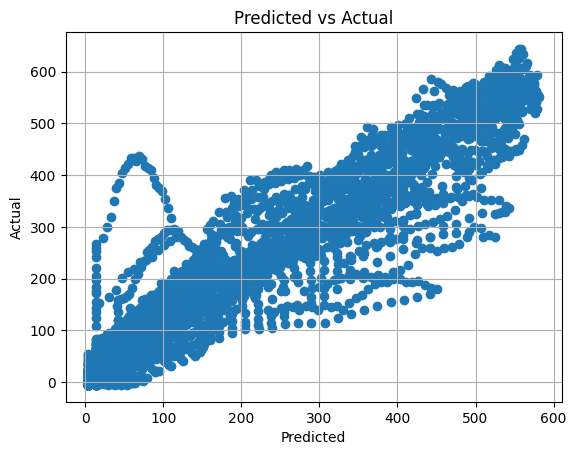

Finished


In [91]:
if __name__ == '__main__':
    # Initialize the network
    model = Net()
    
    # Import data
    data = pd.read_excel(data_path[0])
    
    # Preprocess data
    data = preprocess_data(data)
    
    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(data, train_end=(11,11))

    # Train the network
    model, loss = train_net(model, x_train, y_train, optimiser='Adam', lr=0.1, loss_func='MSE', steps=3000)
    print('Final train loss: ', loss.item())
    
    # Predict the target variable on the testing data
    model.eval()
    prediction = model(x_test)
    
    # Compute the loss on the testing data
    loss = nn.MSELoss()
    test_loss = loss(prediction.squeeze(), y_test)
    print('Test loss: ', test_loss.item())
    
    # Plot the results
    prediction = prediction.detach().numpy()
    y_test = y_test.detach().numpy()
    plt.scatter(prediction, y_test)
    plt.title('Predicted vs Actual')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.grid()
    plt.show()
    
    
    
    print('Finished')